<a href="https://colab.research.google.com/github/jayjay-park/Dynamical-System/blob/main/node_classification_gde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# If you have installed dgl-cuXX package, please uninstall it first.
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [ ]:
!pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import scipy.sparse as sp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

#from torchgde import GCN, GCNLayer, ODEBlock, GDEFunc, PerformanceContainer, accuracy

In [ ]:
import dgl
import dgl.data
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


New..!

In [ ]:
from typing import Callable
import dgl.function as fn

class GCNLayer(nn.Module):
    def __init__(self, g:dgl.DGLGraph, in_feats:int, out_feats:int, activation:Callable[[torch.Tensor], torch.Tensor],
                 dropout:int, bias:bool=True):
        super().__init__()
        self.g = g
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_feats))
        else:
            self.bias = None
        self.activation = activation
        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = 0.
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, h):
        if self.dropout:
            h = self.dropout(h)
        h = torch.mm(h, self.weight)
        # normalization by square root of src degree
        h = h * self.g.ndata['norm']
        self.g.ndata['h'] = h
        self.g.update_all(fn.copy_u('h', 'm'),
                          fn.sum(msg='m', out='h'))
        h = self.g.ndata.pop('h')
        # normalization by square root of dst degree
        h = h * self.g.ndata['norm']
        # bias
        if self.bias is not None:
            h = h + self.bias
        if self.activation:
            h = self.activation(h)
        return h


class GCN(nn.Module):
    def __init__(self, num_layers:int, g:dgl.DGLGraph, in_feats:int, hidden_feats:int,
                 out_feats:int, activation:Callable, dropout:int, bias=True):
        super().__init__()
        self.layers = nn.ModuleList()

        self.layers.append(GCNLayer(g, in_feats, hidden_feats, activation, dropout))

        for i in range(num_layers - 2):
            self.layers.append(GCNLayer(g, hidden_feats, hidden_feats, activation, dropout))

        self.layers.append(GCNLayer(g, hidden_feats, out_feats, None, 0.))

    def set_graph(self, g):
        for l in self.layers:
            l.g = g

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(h)
        return h


In [ ]:
class GDEFunc(nn.Module):
    def __init__(self, gnn:nn.Module):
        """General GDE function class. To be passed to an ODEBlock"""
        super().__init__()
        self.gnn = gnn
        self.nfe = 0
    
    def set_graph(self, g:dgl.DGLGraph):
        for layer in self.gnn:
            layer.g = g
            
    def forward(self, t, x):
        self.nfe += 1
        x = self.gnn(x)
        return x

    
class ControlledGDEFunc(GDEFunc):
    def __init__(self, gnn:nn.Module):
        """ Controlled GDE version. Input information is preserved longer via hooks to input node features X_0, 
            affecting all ODE function steps. Requires assignment of '.h0' before calling .forward"""
        super().__init__(gnn)
        self.nfe = 0
            
    def forward(self, t, x):
        self.nfe += 1
        x = torch.cat([x, self.h0], 1)
        x = self.gnn(x)
        return x

In [ ]:
import torch.nn as nn
import torchdiffeq

class ODEBlock(nn.Module):
    def __init__(self, odefunc:nn.Module, method:str='dopri5', rtol:float=1e-3, atol:float=1e-4, adjoint:bool=True):
        """ Standard ODEBlock class. Can handle all types of ODE functions
            :method:str = {'euler', 'rk4', 'dopri5', 'adams'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x:torch.Tensor, T:int=1):
        self.integration_time = torch.tensor([0, T]).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
            
        return out[-1]
    
    def forward_batched(self, x:torch.Tensor, nn:int, indices:list, timestamps:set):
        """ Modified forward for ODE batches with different integration times """
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i],i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
        
    def trajectory(self, x:torch.Tensor, T:int, num_points:int):
        self.integration_time = torch.linspace(0, t_end, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out

In [ ]:
class PerformanceContainer(object):
    """ Simple data class for metrics logging."""
    def __init__(self, data:dict):
        self.data = data
        
    @staticmethod
    def deep_update(x, y):
        for key in y.keys():
            x.update({key: list(x[key] + y[key])})
        return x

def accuracy(y_hat:torch.Tensor, y:torch.Tensor):
    """ Standard percentage accuracy computation """
    preds = torch.max(y_hat, 1)[1]
    return torch.mean((y == preds).float())

# Semi-supervised node classification 

This notebook introduces `GDEs` as a general high-performance model for graph structured data. Notebook `01_node_classification_gde` is designed from the ground up as an introduction to GDEs and therefore contains ample comments to provide insights on some of our design choices. To be accessible to practicioners/researchers without prior experience on GNNs, we discuss some features of `dgl` as well, one of the PyTorch ecosystems for geometric deep learning.

No prior experience with `Neural ODEs` is required, though we refer to the original repo [torchdiffeq](https://github.com/rtqichen/torchdiffeq) as a complete reference.

## Data preparation

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# seed for repeatability
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# dgl offers convenient access to GNN benchmark datasets via `dgl.data`...
# other standard datasets (e.g. Citeseer / Pubmed) are also accessible via the dgl.data
# API. The rest of the notebook is compatible with Cora / Citeseer / Pubmed with minimal
# modification required.
dataset = dgl.data.CoraGraphDataset()

cora_g = dataset[0]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
# Cora is a node-classification datasets with 2708 nodes
X = torch.FloatTensor(cora_g.ndata['feat']).to(device)
Y = torch.LongTensor(cora_g.ndata['label']).to(device)

# In transductive semi-supervised node classification tasks on graphs, the model has access to all
# node features but only a masked subset of the labels
train_mask = torch.BoolTensor(cora_g.ndata['train_mask'])
val_mask = torch.BoolTensor(cora_g.ndata['val_mask'])
test_mask = torch.BoolTensor(cora_g.ndata['test_mask'])

num_feats = X.shape[1]
n_classes = dataset.num_classes


# 140 training samples, 300 validation, 1000 test
n_classes, train_mask.sum().item(), val_mask.sum().item(),test_mask.sum().item()

(7, 140, 500, 1000)

In [ ]:
print(X[0, 0:20], Y[0])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111]) tensor(3)


- put new X and Y: X (num_node x num_feats (=1)) Y:(num_node x dim(=1))
  - copy and paste X and Y from prev

In [ ]:
def deriv(t, X, a, b):
    """Return the derivatives dx/dt and dy/dt."""
    x, y = X
    dxdt = a - (1+b)*x + x**2 * y
    dydt = b*x - x**2 * y
    return dxdt, dydt

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import random

In [ ]:
# Generate data
np.random.seed(42)

# time iteration
ti, tf = 0, 301
t_eval = np.arange(0, 301, 1).tolist()

# initialize
a = 1
b = 2.02

In [ ]:
# Integrate Brusselator eq for parameters a, b
# solve_ivp: integrates a system of ODE given an initial value
#            (ti, tf) = interval of integration
#            (x0, y0) = initial state
#            dense_output = whether to compute a continuous solution 

# Step 2: Calculate ode for each interaction

ode = solve_ivp(deriv, (ti, tf), (1, 1), dense_output = True, args=(a,b), t_eval = t_eval)
sol = ode.y
print(len(sol[0])) # 2 by 301

301


In [ ]:
# Step 3: Create one graph instance 
#trajectory = [] # len is timestamp, which is in this case, 1500

entire_rate = []
entire_y = []

u = torch.tensor([0])
v = torch.tensor([1])

# for each time stamp,
# 100 graphs with 2 nodes, and node features are dim 1.

g = dgl.graph((u, v), num_nodes=2)
g.ndata["feat"] = torch.tensor([sol[0][0], sol[1][0]])
g.ndata["label"] = torch.tensor([sol[0][1], sol[1][1]])
X = zeros(n_train, n_nodes)
Y = zeros(n_train, n_nodes)
for i in range(n_train):
  X[i] = sol.T[t]
  Y[i] = sol.T[t+1]
  #trajectory.append(g)

# same graph -> 

NameError: ignored

In [ ]:
# Sanity check
g = trajectory[0]
print([sol[0][0], sol[0][1]])
print(g)
print(g.ndata)

In [ ]:
# add self-edge for each node

nxg = dgl.to_networkx(cora_g, node_attrs=['feat', 'label', 'train_mask', 'val_mask', 'test_mask'])
nxg.remove_edges_from(nx.selfloop_edges(nxg))

nxg.add_edges_from(zip(nxg.nodes(), nxg.nodes()))
g = dgl.from_networkx(nxg, node_attrs=['feat', 'label', 'train_mask', 'val_mask', 'test_mask'])

edges = g.edges()
n_edges = g.number_of_edges()

n_edges
print(g.ndata['feat'])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
# g = cora_g

In [ ]:
print((g.ndata['feat'].shape))
print(g)

torch.Size([2708, 1433])
Graph(num_nodes=2708, num_edges=13264,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [ ]:
# compute diagonal of normalization matrix D according to standard formula
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
# add to dgl.Graph in order for the norm to be accessible at training time
g.ndata['norm'] = norm.unsqueeze(1).to(device)

# Graph Neural Differential Equations (GDEs)

As Neural ODEs, GDEs require specification of an ODE function (`ODEFunc`), representing the set of layers that will be called repeatedly by the ODE solver, as well as an ODE block (`ODEBlock`), tasked with calling the ODE solver on the ODE function. The ODEFunc is passed to the ODEBlock at initialization.

We introduce the convolutional variant of GDEs, `GCDEs`. The only difference resides in the type of GNN layer utilized in the ODEFunc.

For adaptive step GDEs (dopri5) we increase the hidden dimension to 64 to reduce the stiffness of the ODE and therefore the number of ODEFunc evaluations (`NFE`: Number Function Evaluation)

In [ ]:
# for GCDEs, the ODEFunc is specified by two GCN layers. Softplus is used as activation. Smoother activations
# have been observed to help avoid numerical instability and reduce stiffness of the ODE described
# by a repeated call to the ODEFunc. High dropout improves performance on transductive node classification
# tasks due to their small training sets. GDEs can take advantage of this property due to their 'deeper'
# computational graph. NOTE: too much dropout increases stiffness and therefore NFEs
gnn = nn.Sequential(GCNLayer(g=g, in_feats=64, out_feats=64, activation=nn.Softplus(), dropout=0.9),
                  GCNLayer(g=g, in_feats=64, out_feats=64, activation=None, dropout=0.9)
                 ).to(device)

gdefunc = GDEFunc(gnn)

# dopri5 is an adaptive step solver and will call `gdefunc` several times to ensure correctness up to pre-specified 
# tolerance levels. rk4 will call the func 4 times. As suggested in the original Neural ODE paper and as observed during internal tests, lower tolerances 
# are sufficient for classification tasks. 
gde = ODEBlock(odefunc=gdefunc, method='rk4', atol=1e-3, rtol=1e-4, adjoint=False).to(device)


m = nn.Sequential(GCNLayer(g=g, in_feats=num_feats, out_feats=64, activation=F.relu, dropout=0.4),
                  gde,
                  GCNLayer(g=g, in_feats=64, out_feats=n_classes, activation=None, dropout=0.)
                  ).to(device)

### Training loop

We use standard hyperparameters for GCNs, namely `1e-2` learning rate and `5e-4` weight decay. For a fair comparison, GDE-dpr5 should be evaluated against deeper GCN models (GCNs with 4+ layers). This is because datasets such as Cora penalize deeper models due to small training sets and thus need for very strong regularizers. GDE-rk4, whose ODEFunc is evaluated only 4 times, should be compared with shallower GCN models.

In [ ]:
opt = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
logger = PerformanceContainer(data={'train_loss':[], 'train_accuracy':[],
                                   'test_loss':[], 'test_accuracy':[],
                                   'forward_time':[], 'backward_time':[],
                                   'nfe': []})
steps = 3000
verbose_step = 150
num_grad_steps = 0

for i in range(steps): # looping over epochs
    m.train()
    start_time = time.time()

    outputs = m(X)
    f_time = time.time() - start_time

    nfe = m._modules['1'].odefunc.nfe

    y_pred = outputs

    loss = criterion(y_pred[train_mask], Y[train_mask])
    opt.zero_grad()
    
    start_time = time.time()
    loss.backward()
    b_time = time.time() - start_time
    
    opt.step()
    num_grad_steps += 1

    with torch.no_grad():
        m.eval()

        # calculating outputs again with zeroed dropout
        y_pred = m(X)
        m._modules['1'].odefunc.nfe = 0

        train_loss = loss.item()
        train_acc = accuracy(y_pred[train_mask], Y[train_mask]).item()
        test_acc = accuracy(y_pred[test_mask], Y[test_mask]).item()
        test_loss = criterion(y_pred[test_mask], Y[test_mask]).item()
        logger.deep_update(logger.data, dict(train_loss=[train_loss], train_accuracy=[train_acc],
                           test_loss=[test_loss], test_accuracy=[test_acc], nfe=[nfe], forward_time=[f_time],
                           backward_time=[b_time]))

    if num_grad_steps % verbose_step == 0:
        print('[{}], Loss: {:3.3f}, Train Accuracy: {:3.3f}, Test Accuracy: {:3.3f}, NFE: {}'.format(num_grad_steps,
                                                                                                    train_loss,
                                                                                                    train_acc,
                                                                                                    test_acc,
                                                                                                    nfe))

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


[150], Loss: 1.705, Train Accuracy: 0.886, Test Accuracy: 0.722, NFE: 4
[300], Loss: 1.312, Train Accuracy: 0.929, Test Accuracy: 0.796, NFE: 4
[450], Loss: 0.929, Train Accuracy: 0.950, Test Accuracy: 0.808, NFE: 4
[600], Loss: 0.644, Train Accuracy: 0.957, Test Accuracy: 0.810, NFE: 4
[750], Loss: 0.468, Train Accuracy: 0.979, Test Accuracy: 0.803, NFE: 4
[900], Loss: 0.441, Train Accuracy: 0.986, Test Accuracy: 0.807, NFE: 4
[1050], Loss: 0.386, Train Accuracy: 0.993, Test Accuracy: 0.799, NFE: 4
[1200], Loss: 0.314, Train Accuracy: 0.993, Test Accuracy: 0.806, NFE: 4
[1350], Loss: 0.309, Train Accuracy: 0.993, Test Accuracy: 0.799, NFE: 4
[1500], Loss: 0.270, Train Accuracy: 0.993, Test Accuracy: 0.800, NFE: 4
[1650], Loss: 0.237, Train Accuracy: 1.000, Test Accuracy: 0.818, NFE: 4
[1800], Loss: 0.200, Train Accuracy: 1.000, Test Accuracy: 0.801, NFE: 4
[1950], Loss: 0.245, Train Accuracy: 0.993, Test Accuracy: 0.813, NFE: 4
[2100], Loss: 0.241, Train Accuracy: 0.993, Test Accuracy

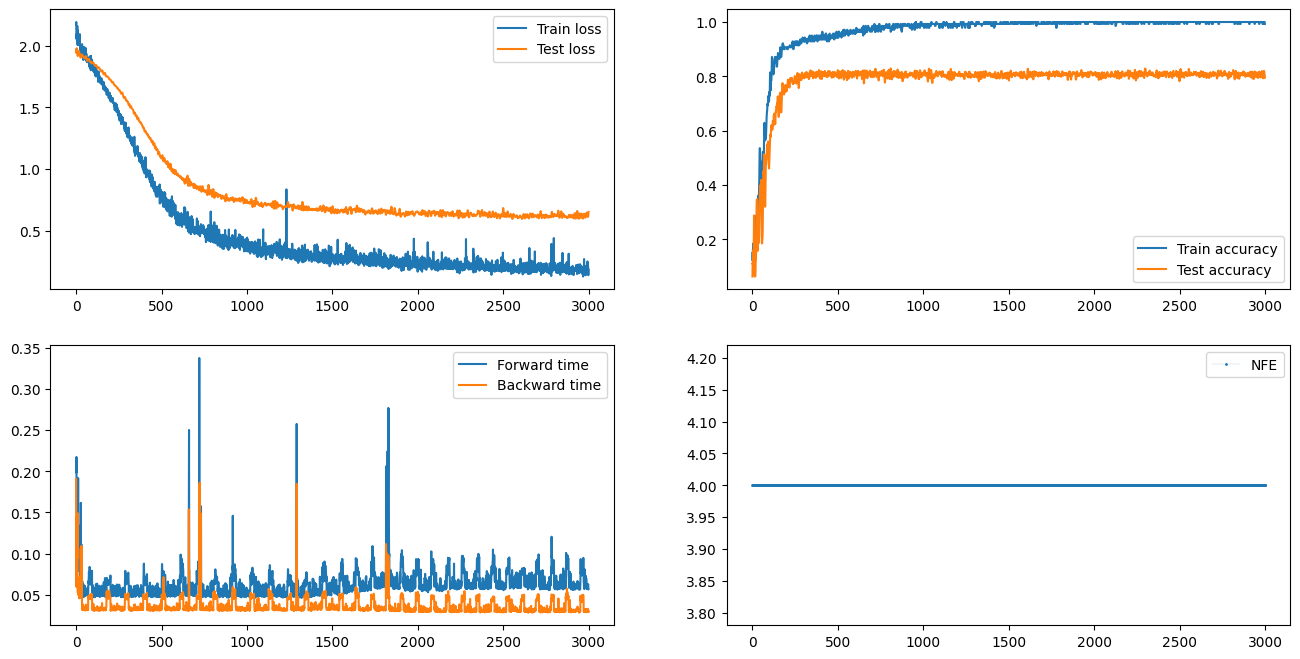

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(logger.data['train_loss'])
plt.plot(logger.data['test_loss'])
plt.legend(['Train loss', 'Test loss'])
plt.subplot(2,2,2)
plt.plot(logger.data['train_accuracy'])
plt.plot(logger.data['test_accuracy'])
plt.legend(['Train accuracy', 'Test accuracy'])
plt.subplot(2,2,3)
plt.plot(logger.data['forward_time'])
plt.plot(logger.data['backward_time'])
plt.legend(['Forward time', 'Backward time'])
plt.subplot(2,2,4)
plt.plot(logger.data['nfe'], marker='o', linewidth=0.1, markersize=1)
plt.legend(['NFE']);

## GCN

We are interested in observing the training behavior of regular GCNs of different layer depths. Below is a training loop
that will collect metrics for GCNs of layers `1, 3, 5, 7`

In [ ]:
loggers = []

for n_layers in range(2, 9, 2):
    
    gcn = GCN(num_layers=n_layers, g=g, in_feats=1433, hidden_feats=64, out_feats=7, activation=F.relu, dropout=0.9).to(device)
    opt = torch.optim.Adam(gcn.parameters(), lr=1e-3, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    num_grad_steps = 3000
    
    gcn_logger = PerformanceContainer(data={'train_loss':[], 'train_accuracy':[],
                                    'test_loss':[], 'test_accuracy':[],
                                    'forward_time':[], 'backward_time':[]}
                                      )
    
    for i in range(num_grad_steps): # looping over epochs  
        start_time = time.time()
        outputs = gcn(X)
        f_time = time.time() - start_time

        y_pred = outputs

        loss = criterion(y_pred[train_mask], Y[train_mask])
        opt.zero_grad()

        start_time = time.time()
        loss.backward()
        b_time = time.time() - start_time
    
        opt.step()
        num_grad_steps += 1

        with torch.no_grad():
            gcn.eval()
            outputs = gcn(X)
            y_pred = outputs
            
            train_loss = loss.item()
            train_acc = accuracy(y_pred[train_mask], Y[train_mask]).item()
            test_acc = accuracy(y_pred[test_mask], Y[test_mask]).item()
            test_loss = criterion(y_pred[test_mask], Y[test_mask]).item()

            gcn_logger.deep_update(gcn_logger.data, dict(train_loss=[train_loss], train_accuracy=[train_acc],
                                   test_loss=[test_loss], test_accuracy=[test_acc], forward_time=[f_time],
                                   backward_time=[b_time]))
            
    loggers.append((gcn_logger, n_layers))

## Comparison plots

GCDEs are shown to be as performing as GDEs, while being deeper and not requiring selection of number of layers. They are observed to converge faster; the high degree of noise present is due to the aggressive dropout setting, used to exploit the increased depth of GCDEs.

In [ ]:
mean_nfe = int(np.array(logger.data['nfe']).mean())
layer_range = range(2, 9, 2)

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(logger.data['train_loss'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['train_loss'])
plt.title('Training loss')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0,2)

plt.subplot(2,2,2)
plt.plot(logger.data['test_loss'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['test_loss'])
plt.title('Test loss')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0,3)

plt.subplot(2,2,3)
plt.plot(logger.data['train_accuracy'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['train_accuracy'])
plt.title('Train accuracy')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])

plt.subplot(2,2,4)
plt.plot(logger.data['test_accuracy'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['test_accuracy'])
plt.title('Test accuracy')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range]);

### Time complexity

The plots below show how forward time for GCDEs is roughly 6 times that of GCN2

In [ ]:
ftime = logger.data['forward_time']
btime = logger.data['backward_time']

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(ftime)
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['forward_time'])
plt.title('Forward time (s)')
plt.legend(['GCDE'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0, 0.006)

plt.subplot(1,2,2)
plt.plot(btime)
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['backward_time'])
plt.title('Backward time (s)')
plt.legend(['GCDE'] + [f'GCN{i}' for i in layer_range]);